In [1]:
from datasets import load_dataset_builder
from datasets import load_dataset
import torch
from torch_geometric.data import Data
import matplotlib.pyplot as plt

from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML

from transformers import AutoTokenizer, GPT2Tokenizer, GPT2LMHeadModel 

import numpy as np
import time

from collections import OrderedDict

from torch_geometric.nn import GCNConv, SimpleConv
from tqdm.auto import tqdm

from torch_geometric.data import Batch

from sklearn.manifold import TSNE

## Helper function

In [2]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()
    

class ModuleHook:
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
        self.module = None
        self.features = []

    def hook_fn(self, module, input, output):
        self.module = module
        self.features.append(output.detach())

    def close(self):
        self.hook.remove()
        
        
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"{task}_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

## Load Dataset

In [3]:
task = "ner" # Should be one of "ner", "pos" or "chunk"
datasets = load_dataset("conll2003")
label_list = datasets["train"].features[f"{task}_tags"].feature.names

model_checkpoint = "gpt2"
batch_size = 16
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)
label_all_tokens = True
tokenized_datasets = datasets.map(tokenize_and_align_labels, batched=True)

model = GPT2LMHeadModel.from_pretrained("gpt2").to("cuda")

Reusing dataset conll2003 (/n/home04/yidachen/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

## Graph Neural Network

In [37]:
from gcn_probe import GCNProbe, GCNNonlinearProbe, MLPProbe

## Create Train & Test Split for Probing Evaluation

In [ ]:
np.random.seed(123)

split = "test"
num_samples = len(datasets["test"])
train_portion = 0.8

sampled_indices = np.random.choice(np.arange(len(tokenized_datasets[split])),
                                   num_samples, 
                                   replace=False)


sampled_train = np.random.choice(np.arange(len(sampled_indices)), 
                                 int(num_samples * train_portion), 
                                 replace=False)


sampled_test = np.setdiff1d(np.arange(len(sampled_indices)), sampled_train)


train_mask = np.array([True] * num_samples)
train_mask[sampled_test] = False


test_mask = np.array([True] * num_samples)
test_mask[sampled_train] = False

## Create Unweighted Directed Graph of Text from pretrained GPT-2

In [39]:
model = GPT2LMHeadModel.from_pretrained("gpt2").to("cuda")
        
threshold = 0.2
    
all_graphs = {}
for layer in range(12):
    all_graphs[layer] = {}
    for head in range(12):
        all_graphs[layer][head] = []
    
# graphs = []


for i in tqdm(sampled_indices):
    features = OrderedDict()
    for name, module in model.named_modules():
        if "c_attn" in name:
            features[name] = ModuleHook(module)


    with torch.no_grad():
        output = model(input_ids = torch.Tensor(tokenized_datasets[split]["input_ids"][i]).type(torch.long).to("cuda"),
                       attention_mask = torch.Tensor(tokenized_datasets[split]["attention_mask"][i]).to("cuda"),
                       output_attentions = True,
                       output_hidden_states = True)


    for feature in features.values():
        feature.close()

    y = tokenized_datasets[split]["labels"][i]
    for layer in range(12):
        value_features = features[f'transformer.h.{layer}.attn.c_attn'].features[0].split(768, dim=2)[-1][0].clone()
        for head in range(12):
            weighted_adj_matrix = output["attentions"][layer][0][head].detach().cpu()

            # node_features = output["hidden_states"][layer - 1][0].detach().cpu()

            node_features = value_features[:, head * 64: (head + 1) * 64]

            adj_matrix = weighted_adj_matrix > threshold

            edge_index = adj_matrix.detach().clone().cpu().nonzero().t().contiguous().type(torch.long)
            x = node_features

            data = Data(x=x, edge_index=edge_index, y=y)

            all_graphs[layer][head].append(data)

  0%|          | 0/3453 [00:00<?, ?it/s]

## Train and Test Helper functions

In [40]:
def train(model, optimizer, criterion, data):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x)  # Perform a single forward pass.
    loss = criterion(out, torch.Tensor(data.y).type(torch.long))  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss


def test(model, data):
    model.eval()
    out = model(data.x)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred == torch.Tensor(data.y)  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(len(data.batch))  # Derive ratio of correct predictions.
    return test_acc

In [27]:
layer = 1
head = 0

probe = MLPProbe(64, 47).to("cuda")

optimizer = torch.optim.Adam(probe.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

train_data = Batch.from_data_list([all_graphs[layer][head][i].to("cuda") for i in range(len(all_graphs[layer][head])) if train_mask[i]])
train_data.y = torch.Tensor(np.concatenate(train_data.y).ravel()).type(torch.long).to("cuda")

test_data = Batch.from_data_list([all_graphs[layer][head][i].to("cuda") for i in range(len(all_graphs[layer][head])) if test_mask[i]])
test_data.y = torch.Tensor(np.concatenate(test_data.y).ravel()).type(torch.long).to("cuda")


for epoch in range(1, 201):
    loss = train(probe, optimizer, criterion, train_data)
    train_acc = test(probe, train_data)
    
    if (epoch - 1) % 20 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
        print(f'Train Accuracy: {train_acc:.4f}')
        
        
test_acc = test(probe, test_data)
print(f'Test Accuracy: {test_acc:.4f}')

Epoch: 001, Loss: 3.7620
Train Accuracy: 0.1892
Epoch: 021, Loss: 2.0455
Train Accuracy: 0.6948
Epoch: 041, Loss: 1.2905
Train Accuracy: 0.7615
Epoch: 061, Loss: 0.9777
Train Accuracy: 0.7899
Epoch: 081, Loss: 0.8242
Train Accuracy: 0.8030
Epoch: 101, Loss: 0.7366
Train Accuracy: 0.8096
Epoch: 121, Loss: 0.6808
Train Accuracy: 0.8144
Epoch: 141, Loss: 0.6427
Train Accuracy: 0.8185
Epoch: 161, Loss: 0.6156
Train Accuracy: 0.8213
Epoch: 181, Loss: 0.5956
Train Accuracy: 0.8231
Test Accuracy: 0.8279


In [28]:
datasets["test"][100]

{'id': '100',
 'tokens': ['Ijaz', 'Ahmad', 'c', 'Spearman', 'b', 'Vaughan', '59'],
 'pos_tags': [22, 22, 34, 22, 34, 22, 11],
 'chunk_tags': [11, 12, 0, 11, 0, 11, 12],
 'ner_tags': [1, 2, 0, 1, 0, 1, 0]}

## Train and Test Helper functions

In [41]:
def train(model, optimizer, criterion, data):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out, torch.Tensor(data.y).type(torch.long))  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss


def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred == torch.Tensor(data.y)  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(len(data.batch))  # Derive ratio of correct predictions.
    return test_acc

## Train Probe on Graph representations of Text at 144 Heads

In [44]:
train_accs = {}
test_accs = {}


for layer in tqdm(range(0, 12)):
    train_accs[layer] = {}
    test_accs[layer] = {}
    for head in range(0, 12):
        probe = GCNProbe(64, 9).to("cuda")
        optimizer = torch.optim.Adam(probe.parameters(), lr=0.01)
        criterion = torch.nn.CrossEntropyLoss()

        # train_data = Batch.from_data_list([graphs[i] for i in range(len(graphs)) if train_mask[i]])
        # train_data.y = np.concatenate(train_data.y).ravel()

        # test_data = Batch.from_data_list([graphs[i] for i in range(len(graphs)) if test_mask[i]])
        # test_data.y = np.concatenate(test_data.y).ravel()


        # train_data = Batch.from_data_list([graphs[i].to("cuda") for i in range(len(graphs)) if train_mask[i]])
        # train_data.y = torch.Tensor(np.concatenate(train_data.y).ravel()).type(torch.long).to("cuda")

        # test_data = Batch.from_data_list([graphs[i].to("cuda") for i in range(len(graphs)) if test_mask[i]])
        # test_data.y = torch.Tensor(np.concatenate(test_data.y).ravel()).type(torch.long).to("cuda")

        train_data = Batch.from_data_list([all_graphs[layer][head][i].to("cuda") for i in range(len(all_graphs[layer][head])) if train_mask[i]])
        train_data.y = torch.Tensor(np.concatenate(train_data.y).ravel()).type(torch.long).to("cuda")

        test_data = Batch.from_data_list([all_graphs[layer][head][i].to("cuda") for i in range(len(all_graphs[layer][head])) if test_mask[i]])
        test_data.y = torch.Tensor(np.concatenate(test_data.y).ravel()).type(torch.long).to("cuda")

        for epoch in range(1, 1001):
            loss = train(probe, optimizer, criterion, train_data)
            train_acc = test(probe, train_data)

        print("-" * 25 + f" layer {layer} head {head} " + "-" * 25)
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
        print(f'Train Accuracy: {train_acc:.4f}')


        test_acc = test(probe, test_data)
        print(f'Test Accuracy: {test_acc:.4f}')
        
        train_accs[layer][head] = train_acc
        test_accs[layer][head] = test_acc

  0%|          | 0/12 [00:00<?, ?it/s]

------------------------- layer 0 head 0 -------------------------
Epoch: 1000, Loss: 0.7298
Train Accuracy: 0.7871
Test Accuracy: 0.8006
------------------------- layer 0 head 1 -------------------------
Epoch: 1000, Loss: 0.5606
Train Accuracy: 0.8158
Test Accuracy: 0.8238
------------------------- layer 0 head 2 -------------------------
Epoch: 1000, Loss: 0.6655
Train Accuracy: 0.7965
Test Accuracy: 0.8111
------------------------- layer 0 head 3 -------------------------
Epoch: 1000, Loss: 0.6591
Train Accuracy: 0.7920
Test Accuracy: 0.8012
------------------------- layer 0 head 4 -------------------------
Epoch: 1000, Loss: 0.6804
Train Accuracy: 0.7863
Test Accuracy: 0.7998
------------------------- layer 0 head 5 -------------------------
Epoch: 1000, Loss: 0.6987
Train Accuracy: 0.7799
Test Accuracy: 0.7962
------------------------- layer 0 head 6 -------------------------
Epoch: 1000, Loss: 0.6722
Train Accuracy: 0.7946
Test Accuracy: 0.8054
------------------------- layer 0 

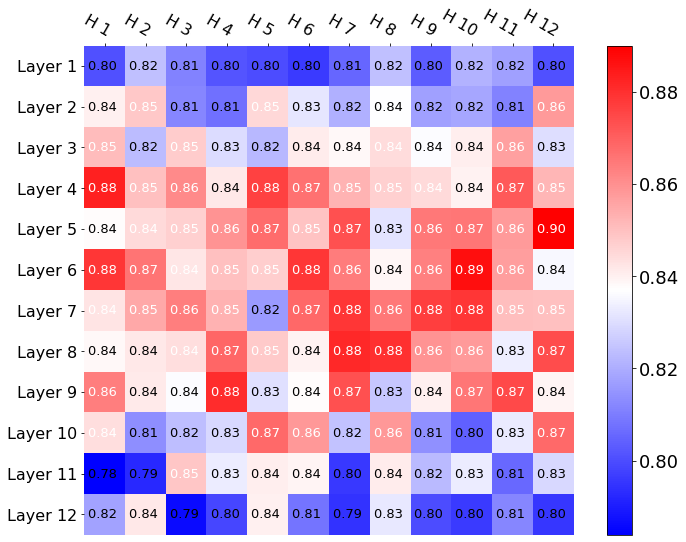

In [53]:
from visualization_utils import heatmap, annotate_heatmap
import matplotlib.pyplot as plt
import numpy as np

score_matrix = []

for layer in range(12):
    score_matrix.append([])
    for head in range(12):
        score_matrix[layer].append(test_accs[layer][head])

plt.figure(figsize=(12, 9))

im, cbar = heatmap(np.array(score_matrix), [f"Layer {i + 1}" for i in range(12)], [f"H {i + 1}" for i in range(12)],
           cmap="bwr", vmax=0.89)

for t in cbar.ax.get_yticklabels():
     t.set_fontsize(18)

texts = annotate_heatmap(im, valfmt="{x:.2f} ", fontsize=13)

In [85]:
import pickle

with open(f"data_layer_{layer}", "wb") as outfile:
    pickle.dump(all_graphs, outfile)

In [ ]:
out = probe(test_data.x, test_data.edge_index)
visualize(out.detach().cpu(), color=test_data.y.detach().cpu())